## Aim

Compute an ABC occurrence rate estimate, and compare results with ```occurrence_mcmc```.

In [1]:
#!/bin/env python  
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
from scipy import optimize, stats, linalg
from utils import dfm
from utils.abc import ABCSampler
# import astroabc

%load_ext autoreload
%autoreload 2

My ABC setup requires

- a prior for the model parameters $\theta$, i.e. a ```stats.continuous_rv/stats.discrete_rv``` object whose .rvs() method returns candidate parameters.
- a sampler for $f(x \mid \theta)$
- distance and statistic functions
- data to fit

I'm not 100% sure how any of these work.

In [2]:
kois = dfm.get_kois()
stellar = dfm.get_stellar()
kois = kois[kois["kepid"].isin(stellar["kepid"])]
# kois = dfm.kois_cuts(kois) - don't do the cuts! Not enough data to work with otherwise

# the only part of the cuts that is necessary is to get rid of NaN radii
kois = kois[np.isfinite(kois["koi_prad"])]

[192950   5222    508    153     59     21      2      2]


Text(0, 0.5, 'Counts')

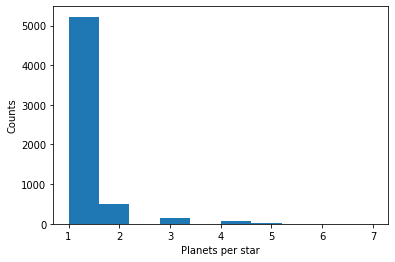

In [3]:
#starcounts = np.concatenate((np.array(pd.crosstab(index=kois['kepid'], columns="count")).flatten(), np.zeros((len(stellar[~stellar["kepid"].isin(kois["kepid"])]),))))
zerocounts = len(stellar[~stellar["kepid"].isin(kois["kepid"])])
solarsyssizes = np.array(pd.crosstab(index=kois['kepid'], columns="count")).flatten()
bincounts = np.bincount(solarsyssizes)
bincounts[0] = zerocounts
print(bincounts)
plt.hist(solarsyssizes)
plt.xlabel("Planets per star")
plt.ylabel("Counts")

Now the dataset has sufficient complexity to fit a Poisson process.

In [4]:
assert np.all(np.isfinite(kois["koi_prad"]))
assert np.all(np.isfinite(kois["koi_period"]))
koi_radii = kois["koi_prad"]
koi_periods = kois["koi_period"]

In [5]:
lam = np.mean(solarsyssizes)
# lam = sum([i * k for i, k in enumerate(bincounts)]) / sum(bincounts)
planet_numbers = np.minimum(stats.poisson(lam).rvs(size=(len(stellar),)), 10)        

(array([6.0904e+04, 7.2332e+04, 4.2550e+04, 1.6786e+04, 4.8610e+03,
        1.1980e+03, 2.4200e+02, 3.3000e+01, 1.0000e+01, 1.0000e+00]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

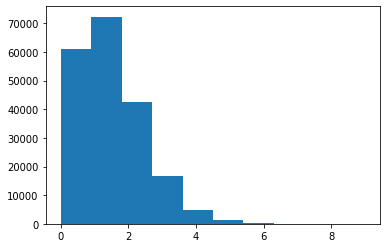

In [6]:
plt.hist(planet_numbers)

In [7]:
period = np.array([0.5, 1.25, 2.5, 5, 10, 20, 40, 80, 160, 320])
rp = np.array([0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 4, 6, 8, 12, 16])
log_p, log_r = np.log(period), np.log(rp)
period_rng = (min(period), max(period))
rp_rng = (min(rp), max(rp))

f = np.histogram2d(koi_periods, koi_radii, bins=[period, rp])[0]
f /= np.sum(f)

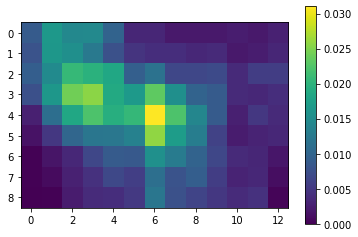

In [8]:
plt.imshow(f) # I guess that's sorta like an H-R diagram?
plt.colorbar()

In [9]:
bucket = np.random.choice(f.size, p=f.flatten())
i, j = bucket // f.shape[1], bucket % f.shape[1]
synth_p = np.exp(np.random.uniform(log_p[i], log_p[i+1]))
synth_r = np.exp(np.random.uniform(log_r[j], log_r[j+1]))
ecc = stats.rayleigh(0.03).rvs()
cosincl = np.random.uniform(-1, 1)
print("Hey look I just made up a planet with period {0} days, radius {1} Earth radii, eccentricity {2}, cos of orbital inclination {3}.".format(np.round(synth_p, 3), np.round(synth_r, 3), np.round(ecc, 3), np.round(cosincl, 3)))

Hey look I just made up a planet with period 158.379 days, radius 2.961 Earth radii, eccentricity 0.755, cos of orbital inclination 0.328.


In [10]:
from scipy.stats import gamma

def get_duration(period, aor, e):
    """
    Equation (1) from Burke et al. This estimates the transit
    duration in the same units as the input period. There is a
    typo in the paper (24/4 = 6 != 4).
    
    :param period: the period in any units of your choosing
    :param aor:    the dimensionless semi-major axis (scaled
                   by the stellar radius)
    :param e:      the eccentricity of the orbit
    
    """
    return 0.25 * period * np.sqrt(1 - e**2) / aor

def get_a(period, mstar, Go4pi=2945.4625385377644/(4*np.pi*np.pi)):
    """
    Compute the semi-major axis of an orbit in Solar radii.
    
    :param period: the period in days
    :param mstar:  the stellar mass in Solar masses
    
    """
    return (Go4pi*period*period*mstar) ** (1./3)

def get_delta(k, c=1.0874, s=1.0187):
    """
    Estimate the approximate expected transit depth as a function
    of radius ratio. There might be a typo here. In the paper it
    uses c + s*k but in the public code, it is c - s*k:
    https://github.com/christopherburke/KeplerPORTs
    
    :param k: the dimensionless radius ratio between the planet and
              the star
    
    """
    delta_max = k*k * (c + s*k)
    return 0.84 * delta_max

cdpp_cols = [k for k in stellar.keys() if k.startswith("rrmscdpp")]
cdpp_vals = np.array([k[-4:].replace("p", ".") for k in cdpp_cols], dtype=float)
def get_mes(star, period, rp, tau, re=0.009171):
    """
    Estimate the multiple event statistic value for a transit.
    
    :param star:   a pandas row giving the stellar properties
    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param tau:    the transit duration in hours
    
    """
    # Interpolate to the correct CDPP for the duration.
    cdpp = np.array(star[cdpp_cols], dtype=float)
    sigma = np.interp(tau, cdpp_vals, cdpp)

    # Compute the radius ratio and estimate the S/N.
    k = rp * re / star.radius
    snr = get_delta(k) * 1e6 / sigma
    
    # Scale by the estimated number of transits.
    ntrn = star.dataspan * star.dutycycle / period 
    return snr * np.sqrt(ntrn)

# Pre-compute and freeze the gamma function from Equation (5) in
# Burke et al.
pgam = gamma(4.65, loc=0., scale=0.98)
mesthres_cols = [k for k in stellar.keys() if k.startswith("mesthres")]
mesthres_vals = np.array([k[-4:].replace("p", ".") for k in mesthres_cols],
                         dtype=float)
def get_pdet(star, aor, period, rp, e):
    """
    Equation (5) from Burke et al. Estimate the detection efficiency
    for a transit.
    
    :param star:   a pandas row giving the stellar properties
    :param aor:    the dimensionless semi-major axis (scaled
                   by the stellar radius)
    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param e:      the orbital eccentricity
    
    """
    tau = get_duration(period, aor, e) * 24.
    mes = get_mes(star, period, rp, tau)
    mest = np.interp(tau, mesthres_vals,
                     np.array(star[mesthres_cols],
                              dtype=float))
    x = mes - 4.1 - (mest - 7.1)
    return pgam.cdf(x)

def get_pwin(star, period):
    """
    Equation (6) from Burke et al. Estimates the window function
    using a binomial distribution.
    
    :param star:   a pandas row giving the stellar properties
    :param period: the period in days
    
    """
    M = star.dataspan / period
    f = star.dutycycle
    omf = 1.0 - f
    pw = 1 - omf**M - M*f*omf**(M-1) - 0.5*M*(M-1)*f*f*omf**(M-2)
    msk = (pw >= 0.0) * (M >= 2.0)
    return pw * msk

def get_pgeom(aor, e):
    """
    The geometric transit probability.
    
    See e.g. Kipping (2014) for the eccentricity factor
    http://arxiv.org/abs/1408.1393
    
    :param aor: the dimensionless semi-major axis (scaled
                by the stellar radius)
    :param e:   the orbital eccentricity
    """
    # do I not want a cos(i) in here?
    return 1. / (aor * (1 - e*e)) * (aor > 1.0)

def pcomp(star, period, rp, e, with_geom=True):
    """
    A helper function to combine all the completeness effects.
    
    :param star:      a pandas row giving the stellar properties
    :param period:    the period in days
    :param rp:        the planet radius in Earth radii
    :param e:         the orbital eccentricity
    :param with_geom: include the geometric transit probability?
    
    """
    aor = get_a(period, star.mass) / star.radius
    pdet = get_pdet(star, aor, period, rp, e)
    pwin = get_pwin(star, period)
    if not with_geom:
        return pdet * pwin
    pgeom = get_pgeom(aor, e)
    return pdet * pwin * pgeom

/usr/local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


(array([4.047e+03, 1.538e+03, 6.090e+02, 3.740e+02, 2.710e+02, 1.700e+02,
        3.600e+01, 1.100e+01, 7.000e+00, 1.000e+00]),
 array([0.        , 0.05934643, 0.11869286, 0.17803929, 0.23738572,
        0.29673215, 0.35607858, 0.41542501, 0.47477144, 0.53411787,
        0.5934643 ]),
 <a list of 10 Patch objects>)

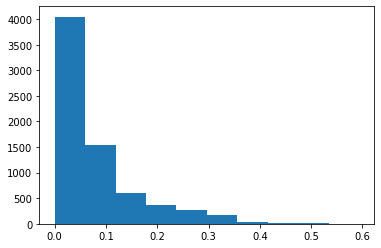

In [11]:
combined = pd.merge(kois, stellar, on='kepid')
plt.hist(pcomp(combined.iloc[0], combined['koi_period'], combined['koi_prad'], combined['koi_eccen']))

In [12]:
all(combined['koi_eccen'] == 0)

True

In [13]:
kois['koi_depth']

0       14186.4
1        6690.6
2         458.3
3        9379.3
4         265.7
         ...   
7343    14620.9
7344      324.3
7345      288.3
7346      434.8
7347      475.9
Name: koi_depth, Length: 7064, dtype: float64

In [14]:
aor = get_a(combined['koi_period'], combined['mass']) / combined['radius']
transit_durations = combined['koi_period'] / np.pi * np.arcsin(np.sqrt(1 + combined['koi_ror']**2 - combined['koi_impact']**2) / aor)
np.count_nonzero(~np.isnan(transit_durations))

/usr/local/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in arcsin
  result = getattr(ufunc, method)(*inputs, **kwargs)


6061

In [15]:
np.count_nonzero(np.isnan(1 + combined['koi_ror']**2 - combined['koi_impact']**2) / aor)

92

In [16]:
min(1 + combined['koi_ror']**2 - combined['koi_impact']**2)

-197.74211707199538

In [17]:
np.array(combined['koi_ror'])[np.where(combined['koi_ror'] > 1)]

array([29.233711, 12.87936 ,  4.210016,  3.210206, 36.527225,  1.847289,
       43.61377 , 26.379158, 22.473545, 40.047718, 96.046448, 16.250244,
        3.228014, 33.756237, 34.844692, 25.689688, 22.661406, 72.991737,
        6.416173,  2.734658,  1.100073, 88.775139,  3.117785, 98.359161,
        5.751969, 70.579384, 59.574707, 61.072872, 10.723516,  8.037216,
       36.802391, 97.605156,  3.418653, 94.307571,  2.794919, 35.500751,
       88.920593,  5.687459,  1.76501 , 91.576218, 30.353176, 51.279797,
       55.442379,  1.794136, 67.439331, 82.471077, 15.077429,  2.528085,
        3.665677,  1.021342, 24.365004,  5.338659,  1.830554,  1.439245,
        1.328312,  1.143039, 23.750204, 85.506981,  1.325495,  1.061064,
        1.295101,  2.265499,  1.461621, 13.750893,  7.490508,  1.996093,
       44.56646 ,  3.344967, 13.881475,  4.621942,  4.011199,  1.158661,
        3.253776,  1.381155, 29.961012,  3.467842, 22.193785, 34.221661,
        1.178534, 25.416222,  5.505023,  3.734224, 

In [18]:
max(combined['koi_prad'] / combined['radius'] * 0.009168)

100.09643454817774

In [19]:
max(combined['koi_ror'])

99.98200200000001

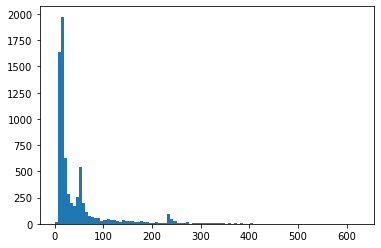

In [20]:
_ = plt.hist(np.sort(kois['koi_time0']) - min(kois['koi_time0']), bins=100)

In [21]:
class SyntheticPlanet:
    # :)
    def __init__(self, star, period, radius, ecc, incl):
        pass

In [22]:
from multiprocessing import Pool
p = Pool(5)
def f(x):
    return x * x

%timeit map(f, list(range(int(1e6))))
%timeit p.map(f, list(range(int(1e6))))

44.6 ms ± 267 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


TypeError: 'numpy.ndarray' object is not callable